# [**Estimateur unique versus bagging : décomposition biais-variance**](https://nbviewer.org/github/Franck-PepperLabs/pepper_data-science_practising/blob/main/Sklearn/examples/1_11_ensemble/plot_bias_variance.ipynb)<br/>([_Single estimator versus bagging: bias-variance decomposition_](https://scikit-learn.org/stable/auto_examples/ensemble/plot_bias_variance.html))

Cet exemple illustre et compare la **décomposition biais-variance** de l'erreur quadratique moyenne attendue d'un seul estimateur par rapport à un ensemble de bagging.

Dans la régression, l'erreur quadratique moyenne attendue d'un estimateur peut être décomposée en termes de biais, de variance et de bruit. En moyenne sur les ensembles de données du problème de régression, le terme de biais mesure la quantité moyenne par laquelle les prédictions de l'estimateur diffèrent des prédictions du meilleur estimateur possible pour le problème (c'est-à-dire le modèle de Bayes). Le terme de variance mesure la variabilité des prédictions de l'estimateur lorsqu'il est ajusté sur différentes instances aléatoires du même problème. Par la suite, chaque instance de problème est notée « LS », pour « Learning Sample ». Enfin, le bruit mesure la part irréductible de l'erreur due à la variabilité des données.

La figure en haut à gauche illustre les prédictions (en rouge foncé) d'un arbre de décision unique entraîné sur un ensemble de données aléatoires LS (les points bleus) d'un problème de régression factice 1D. Il illustre également les prédictions (en rouge clair) d'autres arbres de décision simples entraînés sur d'autres (et différentes) instances LS  du problème tirées au hasard. Intuitivement, le terme de variance correspond ici à la largeur du faisceau de prédictions (en rouge clair) des estimateurs individuels. Plus la variance est grande, plus les prédictions pour `x` sont sensibles aux petits changements dans l'ensemble d'apprentissage. Le terme de biais correspond à la différence entre la prédiction moyenne de l'estimateur (en cyan) et le meilleur modèle possible (en bleu foncé). Sur ce problème, on peut ainsi observer que le biais est assez faible (les deux courbes cyan et bleue sont proches l'une de l'autre) tandis que la variance est grande (le faisceau rouge est plutôt large).

La figure en bas à gauche trace la décomposition ponctuelle de l'erreur quadratique moyenne attendue d'un seul arbre de décision. Cela confirme que le terme de biais (en bleu) est faible alors que la variance est grande (en vert). Il illustre également la partie bruit de l'erreur qui, comme prévu, semble être constante et autour de `0.01`.

Les chiffres de droite correspondent aux mêmes diagrammes mais en utilisant à la place un ensemble d'arbres de décision. Dans les deux figures, nous pouvons observer que le terme de biais est plus grand que dans le cas précédent. Dans la figure en haut à droite, la différence entre la prédiction moyenne (en cyan) et le meilleur modèle possible est plus grande (par exemple, notez le décalage autour de `x=2`). Dans la figure en bas à droite, la courbe de biais est également légèrement plus élevée que dans la figure en bas à gauche. En termes de variance cependant, le faisceau de prédictions est plus étroit, ce qui suggère que la variance est plus faible. En effet, comme le confirme la figure en bas à droite, le terme de variance (en vert) est plus faible que pour les arbres de décision simples. Globalement, la décomposition biais-variance n'est donc plus la même. Le compromis est meilleur pour le bagging : faire la moyenne de plusieurs arbres de décision ajustés sur des copies bootstrap de l'ensemble de données augmente légèrement le terme de biais mais permet une plus grande réduction de la variance, ce qui se traduit par une erreur quadratique moyenne globale plus faible (comparez les courbes rouges dans la partie inférieure Les figures). La sortie du script confirme également cette intuition. L'erreur totale de l'ensemble d'ensachage est inférieure à l'erreur totale d'un seul arbre de décision, et cette différence provient en effet principalement d'une variance réduite.

Pour plus de détails sur la décomposition biais-variance, voir la section 7.3 de [1].

## Références

📚 [1] T. Hastie, R. Tibshirani et J. Friedman, [**“Elements of Statistical Learning Ed. 2”**](https://hastie.su.domains/Papers/ESLII.pdf), Springer, 2009.

Tree: 0.0255 (error) = 0.0003 (bias^2)  + 0.0152 (var) + 0.0098 (noise)
Bagging(Tree): 0.0196 (error) = 0.0004 (bias^2)  + 0.0092 (var) + 0.0098 (noise)


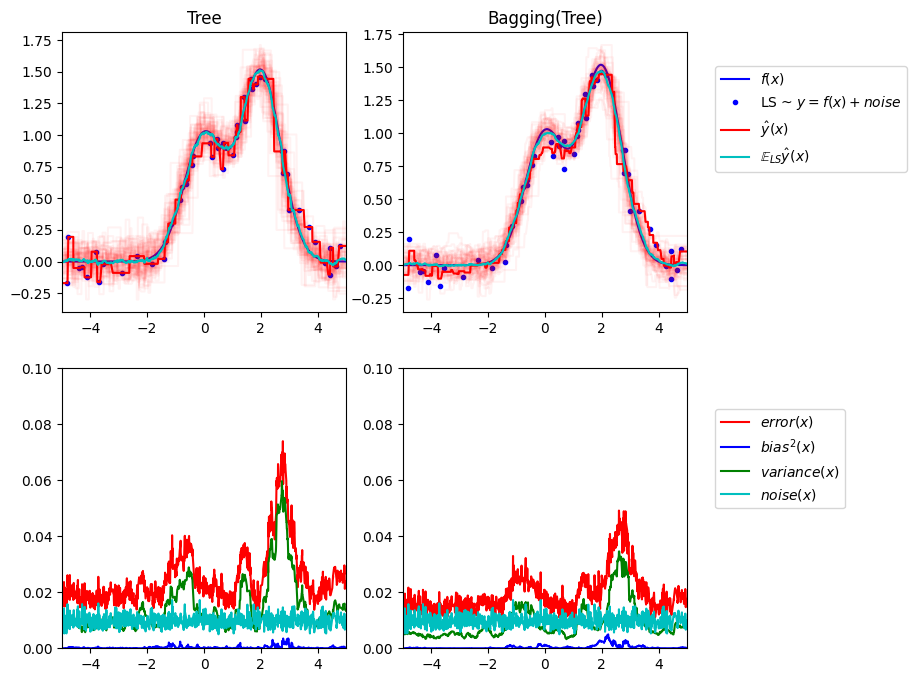

In [1]:
# Author: Gilles Louppe <g.louppe@gmail.com>
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

# Settings
n_repeat = 50  # Number of iterations for computing expectations
n_train = 50  # Size of the training set
n_test = 1000  # Size of the test set
noise = 0.1  # Standard deviation of the noise
np.random.seed(0)

# Change this for exploring the bias-variance decomposition of other
# estimators. This should work well for estimators with high variance (e.g.,
# decision trees or KNN), but poorly for estimators with low variance (e.g.,
# linear models).
estimators = [
    ("Tree", DecisionTreeRegressor()),
    ("Bagging(Tree)", BaggingRegressor(DecisionTreeRegressor())),
]

n_estimators = len(estimators)


# Generate data
def f(x):
    x = x.ravel()

    return np.exp(-(x**2)) + 1.5 * np.exp(-((x - 2) ** 2))


def generate(n_samples, noise, n_repeat=1):
    X = np.random.rand(n_samples) * 10 - 5
    X = np.sort(X)

    if n_repeat == 1:
        y = f(X) + np.random.normal(0.0, noise, n_samples)
    else:
        y = np.zeros((n_samples, n_repeat))

        for i in range(n_repeat):
            y[:, i] = f(X) + np.random.normal(0.0, noise, n_samples)

    X = X.reshape((n_samples, 1))

    return X, y


X_train = []
y_train = []

for i in range(n_repeat):
    X, y = generate(n_samples=n_train, noise=noise)
    X_train.append(X)
    y_train.append(y)

X_test, y_test = generate(n_samples=n_test, noise=noise, n_repeat=n_repeat)

plt.figure(figsize=(10, 8))

# Loop over estimators to compare
for n, (name, estimator) in enumerate(estimators):
    # Compute predictions
    y_predict = np.zeros((n_test, n_repeat))

    for i in range(n_repeat):
        estimator.fit(X_train[i], y_train[i])
        y_predict[:, i] = estimator.predict(X_test)

    # Bias^2 + Variance + Noise decomposition of the mean squared error
    y_error = np.zeros(n_test)

    for i in range(n_repeat):
        for j in range(n_repeat):
            y_error += (y_test[:, j] - y_predict[:, i]) ** 2

    y_error /= n_repeat * n_repeat

    y_noise = np.var(y_test, axis=1)
    y_bias = (f(X_test) - np.mean(y_predict, axis=1)) ** 2
    y_var = np.var(y_predict, axis=1)

    print(
        "{0}: {1:.4f} (error) = {2:.4f} (bias^2) "
        " + {3:.4f} (var) + {4:.4f} (noise)".format(
            name, np.mean(y_error), np.mean(y_bias), np.mean(y_var), np.mean(y_noise)
        )
    )

    # Plot figures
    plt.subplot(2, n_estimators, n + 1)
    plt.plot(X_test, f(X_test), "b", label="$f(x)$")
    plt.plot(X_train[0], y_train[0], ".b", label="LS ~ $y = f(x)+noise$")

    for i in range(n_repeat):
        if i == 0:
            plt.plot(X_test, y_predict[:, i], "r", label=r"$\^y(x)$")
        else:
            plt.plot(X_test, y_predict[:, i], "r", alpha=0.05)

    plt.plot(X_test, np.mean(y_predict, axis=1), "c", label=r"$\mathbb{E}_{LS} \^y(x)$")

    plt.xlim([-5, 5])
    plt.title(name)

    if n == n_estimators - 1:
        plt.legend(loc=(1.1, 0.5))

    plt.subplot(2, n_estimators, n_estimators + n + 1)
    plt.plot(X_test, y_error, "r", label="$error(x)$")
    plt.plot(X_test, y_bias, "b", label="$bias^2(x)$"),
    plt.plot(X_test, y_var, "g", label="$variance(x)$"),
    plt.plot(X_test, y_noise, "c", label="$noise(x)$")

    plt.xlim([-5, 5])
    plt.ylim([0, 0.1])

    if n == n_estimators - 1:

        plt.legend(loc=(1.1, 0.5))

plt.subplots_adjust(right=0.75)
plt.show()